<a href="https://colab.research.google.com/github/jrsansom110515/team2_w25_milestone2_datafiles/blob/main/team2_w25_milestone2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install pycaret

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import warnings

In [2]:
"""Clone the git repository that holds the CSV files"""
!git clone https://github.com/jrsansom110515/team2_w25_milestone2_datafiles.git

Cloning into 'team2_w25_milestone2_datafiles'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 18 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 1.92 MiB | 7.61 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [3]:
""" This cell contains key functions used through out the remaining workbook"""

# Function to load in datasets

def load_data_csv(files_list):
    if len(files_list) != 2:
        raise ValueError("files_list must contain exactly two file names.")

    # Replace the file path with your location.
    MLB_df = pd.read_csv('/content/team2_w25_milestone2_datafiles/' + files_list[1])
    MiLB_df = pd.read_csv('/content/team2_w25_milestone2_datafiles/' + files_list[0])

    return MiLB_df, MLB_df


# Function to merge datasets and create a new column from the playerID to signify MLB debut

def merge_datasets(MiLB_df, MLB_df):
    MiLB_df['PlayerId'] = MiLB_df['PlayerId'].astype(str)
    MLB_df['PlayerId'] = MLB_df['PlayerId'].astype(str)

    merged_df = MiLB_df.merge(MLB_df[['PlayerId']], on = 'PlayerId', how = 'left', indicator = True)

    merged_df['MLB_debut'] = merged_df['_merge'].apply(lambda x: 1 if x == 'both' else 0)

    merged_df = merged_df.drop(columns=['PlayerId', '_merge', 'Name', 'Team'])

    return merged_df


# Function to extract age and level

def age_level(MiLB_m_df):

    # Get max age
    MiLB_m_df['max_age'] = MiLB_m_df['Age'].apply(lambda x: x.split('-')[1]).astype(int)

    # Get levels into dummy variables
    dummy_df = MiLB_m_df['Level'].str.get_dummies(',')
    dummy_df['num_level'] = dummy_df.sum(axis = 1)
    MiLB_m_df = pd.concat([MiLB_m_df,dummy_df], axis=1)
    MiLB_m_df = MiLB_m_df.drop(columns=['Level', 'Age'])

    return MiLB_m_df


# Function combine two datasets for train_test_split

def combine_dataset(df1, df2):
  combine_df_NA = pd.concat([df1, df2], axis = 0).reset_index(drop = True)
  combine_df = combine_df_NA.dropna(axis = 1)

  return combine_df


# Function to define features for X and y and to create a custom split of 0 and 1 in the target variable, the return is the train and test variables

def custom_training_testing(df, target_feature, train_size_0, train_size_1):
  """
    Parameters:
    df (pd.DataFrame): The dataset.
    target_feature (str): The name of the target column.
    train_size_0 (float): Proportion of class 0 to keep in training.
    train_size_1 (float): Proportion of class 1 to keep in training.
  """
  no_mlb_debut_0 = df[df[target_feature] == 0]
  yes_mlb_debut_1 = df[df[target_feature] == 1]

  df_0_train, df_0_test = train_test_split(no_mlb_debut_0, train_size = train_size_0, random_state = 42)
  df_1_train, df_1_test = train_test_split(yes_mlb_debut_1, train_size = train_size_1, random_state = 42)

  df_train = pd.concat([df_0_train, df_1_train]).sample(frac = 1, random_state = 42)
  df_test = pd.concat([df_0_test, df_1_test]).sample(frac = 1, random_state = 42)

  X_train, y_train = df_train.drop(columns = [target_feature]), df_train[target_feature]
  X_test, y_test = df_test.drop(columns = [target_feature]), df_test[target_feature]

  return X_train, X_test, y_train, y_test


# Function to define features for X and y to setup and perform testing with custom test size and parameters, the return is the train and test variables

def standard_training_testing(df, target_feature, test_size):
  X = df.drop(columns = [target_feature])
  y = df[target_feature]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42, stratify = y)

  return X_train, X_test, y_train, y_test


# Function to Groupby matrix to see which levels have the most MLB debuts in the dataset

def levels_mlb_debut(df):
  levels = ['A', 'A+', 'AA', 'AAA']

  ratios = {}

  for level in levels:
    num_with_mlb_debut = df[(df[level] == 1) & (df['MLB_debut'] == 1)].shape[0]
    total_level_count = df[df[level] == 1].shape[0]

    ratio = num_with_mlb_debut / total_level_count if total_level_count != 0 else 0

    ratios[level] = round(ratio, 2)

  return ratios

In [4]:
"""
Datasets that contains all MiLB batter data and datasets for MLB debut

These datasets names are the same as the ones previously shared, so these lists should be fine
as long as the names are not changed.
"""
milb_18_20, mlb_21_22 = load_data_csv(['Historical_MiLB_players_dataset_2018_2020.csv', 'MLB_debut_2021_2022.csv'])
milb_19_21, mlb_22_23 = load_data_csv(['Historical_MiLB_players_dataset_2019_2021.csv', 'MLB_debut_2022_2023.csv'])
milb_20_22, mlb_23_24 = load_data_csv(['Historical_MiLB_players_dataset_2020_2022.csv', 'MLB_debut_2023_2024.csv'])

In [5]:
milb_18_20.head()

,Name,Team,Level,Age,PA,BB%,K%,BB/K,AVG,OBP,...,OPS,ISO,Spd,BABIP,wSB,wRC,wRAA,wOBA,wRC+,PlayerId
0,Christian Bethancourt,MIL,AAA,26-26,418,0.047847,0.181818,0.263158,0.296675,0.327751,...,0.834145,0.209719,3.856732,0.318937,0.664623,61.600626,7.035243,0.358492,112.893234,10028
1,Tomas Telis,MIA,AAA,27-28,633,0.056872,0.099526,0.571429,0.319728,0.360759,...,0.806338,0.125850,3.715513,0.340426,-0.261360,90.123040,5.657395,0.349854,106.467915,10067
2,Nick Franklin,MIL,"A+,AA,AAA,R",27-28,416,0.125000,0.185096,0.675325,0.257062,0.351807,...,0.775536,0.166667,5.337587,0.296703,-0.062833,56.880421,0.111199,0.342564,101.249987,10166
3,Francisco Arcia,LAA,"AA,AAA",28-29,432,0.050926,0.162037,0.314286,0.232737,0.287059,...,0.588849,0.069054,3.268657,0.271875,-1.108097,29.449425,-29.670384,0.267188,52.290427,10286
4,Danny Ortiz,PHI,AAA,28-28,418,0.045455,0.241627,0.188119,0.232143,0.270335,...,0.668294,0.165816,1.629498,0.271429,-0.482535,39.405764,-7.674912,0.295148,83.698381,10317


In [6]:
"""
Merged datasets creating a new column of MLB debut with a 1 if player made debut in these years or 0 if they did not

Change the age column and level from a categorical variable to a numeric variable for modeling purposes
"""

# merge the above datasets
milb_18_20_mlb_21_22 = merge_datasets(milb_18_20, mlb_21_22)
milb_19_21_mlb_22_23 = merge_datasets(milb_19_21, mlb_22_23)
milb_20_22_mlb_23_24 = merge_datasets(milb_20_22, mlb_23_24)

# change the age and level columns to numeric
milb_18_20_mlb_21_22 = age_level(milb_18_20_mlb_21_22)
milb_19_21_mlb_22_23 = age_level(milb_19_21_mlb_22_23)
milb_20_22_mlb_23_24 = age_level(milb_20_22_mlb_23_24)


In [7]:
milb_20_22_mlb_23_24.head()

,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,...,wRC+,MLB_debut,max_age,A,A+,AA,AAA,CPX,DSL,num_level
0,766,0.073107,0.116188,0.629213,0.292264,0.350327,0.388252,0.738579,0.095989,3.220497,...,96.863135,0,31,0,0,0,1,0,0,1
1,407,0.110565,0.113022,0.978261,0.276056,0.358722,0.380282,0.739004,0.104225,4.243838,...,103.285626,0,29,0,0,0,1,0,0,1
2,581,0.201377,0.277108,0.726708,0.219298,0.375215,0.434211,0.809426,0.214912,3.606748,...,118.465065,0,30,0,0,0,1,0,0,1
3,350,0.122857,0.194286,0.632353,0.221854,0.328571,0.430464,0.759035,0.208609,2.678690,...,104.487300,0,28,0,0,0,1,0,0,1
4,534,0.104869,0.301498,0.347826,0.208238,0.343985,0.393593,0.737578,0.185355,2.294989,...,103.853435,0,32,0,0,1,1,0,0,2


In [8]:
"""Create the dataset for train_test_split to use on the datasets"""

tts_dataset = combine_dataset(milb_18_20_mlb_21_22, milb_19_21_mlb_22_23)


In [9]:
"""Groupby matrix to see which levels have the most MLB debuts in the dataset"""

level_ratio_df = levels_mlb_debut(tts_dataset)
level_ratio_df

{'A': 0.06, 'A+': 0.08, 'AA': 0.1, 'AAA': 0.09}

In [10]:
"""Reduce the size of the dataset down to only players who have played at certain levels"""

tts_dataset_higher_levels = tts_dataset.loc[(tts_dataset['AA'] == 1) & (tts_dataset['AAA'] == 1)].drop(columns=['A', 'A+', 'A-', 'R'])

tts_dataset_higher_levels.head(5)

,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,...,wSB,wRC,wRAA,wOBA,wRC+,MLB_debut,max_age,AA,AAA,num_level
2,416,0.125000,0.185096,0.675325,0.257062,0.351807,0.423729,0.775536,0.166667,5.337587,...,-0.062833,56.880421,0.111199,0.342564,101.249987,0,28,1,1,4
3,432,0.050926,0.162037,0.314286,0.232737,0.287059,0.301790,0.588849,0.069054,3.268657,...,-1.108097,29.449425,-29.670384,0.267188,52.290427,0,29,1,1,2
7,450,0.071111,0.220000,0.323232,0.281095,0.344444,0.512438,0.856882,0.231343,1.397938,...,-0.081083,71.015225,13.827388,0.370371,123.280695,0,27,1,1,3
9,505,0.041584,0.168317,0.247059,0.278132,0.307229,0.371550,0.678779,0.093418,2.847424,...,-0.528534,49.671146,-18.555397,0.299820,72.961260,0,31,1,1,2
12,515,0.058252,0.141748,0.410959,0.255864,0.307393,0.441365,0.748758,0.185501,0.912088,...,-0.040043,64.625179,6.015183,0.332961,111.136248,0,28,1,1,2


# Supervised Learning

In [33]:
"""
Run the function from the function list to return X_train, X_test, y_train, y_test

The function takes 4 inputs. 1 dataframe,
1 string name of the feature column that is the dependent variable,
a training size for did NOT make MLB debut (0) and training size for did make MLB debut (1)
"""

# Training weight for each class within the model
mlb_debut_yes = 0.60
mlb_debut_no = 0.40

X_train, X_test, y_train, y_test = custom_training_testing(tts_dataset_higher_levels,'MLB_debut', mlb_debut_no, mlb_debut_yes)


""" Use models to start training and testing """

""" All features in this instance of the models """

print('-------------------------------------------------------------------------')

# Logistic Regression Classification
print("Logistic Regression Model (Probabilistic)")
lr_model = LogisticRegression(class_weight = 'balanced', max_iter = 10000, random_state = 42)

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

acc_test_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy on Split Test Set: {acc_test_lr:.2f}")
print("\nLogistic Regression Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_lr))

print('-------------------------------------------------------------------------')

# Extra Trees model
print("Extra Trees Model (Tree-Based)")
et_model = ExtraTreesClassifier(n_estimators = 1000, bootstrap = False, random_state = 42)

et_model.fit(X_train, y_train)

y_pred_et = et_model.predict(X_test)

acc_test_et = accuracy_score(y_test, y_pred_et)
print(f"Extra Trees Accuracy on Split Test Set: {acc_test_et:.2f}")
print("\nExtra Trees Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_et))

print('-------------------------------------------------------------------------')

# kNN Classifier Model
print("k-Nearest Neighbor Model (Instance-Based)")

#weighted kNN classifier with model parameter tuning
scores = []
k = range(1,10+1)

for i in k:
  knn = KNeighborsClassifier(n_neighbors = i, weights='distance')
  knn.fit(X_train, y_train)
  scores.append(knn.score(X_test, y_test))

k_best = k[int(np.argsort(scores)[-1])]


knn_model = KNeighborsClassifier(n_neighbors = k_best, weights='distance')

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

acc_test_knn = accuracy_score(y_test, y_pred_knn)
print("Optimal value of k: ", k_best)
print(f"k-Nearest Neighbor Accuracy on Split Test Set: {acc_test_knn:.2f}")
print("\nk-Nearest Neighbor Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_knn))

print('-------------------------------------------------------------------------')

-------------------------------------------------------------------------
Logistic Regression Model (Probabilistic)
Logistic Regression Accuracy on Split Test Set: 0.71

Logistic Regression Classification Report on Split Test Set:
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       480
           1       0.18      0.80      0.30        40

    accuracy                           0.71       520
   macro avg       0.58      0.75      0.56       520
weighted avg       0.92      0.71      0.78       520

-------------------------------------------------------------------------
Extra Trees Model (Tree-Based)
Extra Trees Accuracy on Split Test Set: 0.91

Extra Trees Classification Report on Split Test Set:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       480
           1       0.26      0.12      0.17        40

    accuracy                           0.91       520
   macro avg       0

In [34]:
""" Extract the most important features for Logistic Regression and Gradient Boosting model """

feature_importance_lr = pd.DataFrame({'Feature': X_train.columns, 'LR Importance': lr_model.coef_[0]})
feature_importance_et = pd.DataFrame({'Feature': X_train.columns, 'ET Importance': et_model.feature_importances_})

combined_importance = pd.merge(feature_importance_lr, feature_importance_et, on="Feature")

filtered_importance = combined_importance[(combined_importance['LR Importance'] > 0) & (combined_importance['ET Importance'] > 0)]

filtered_importance = filtered_importance.sort_values(by='LR Importance', ascending=False)

# Keep only the features that have a positive impact on both models
filtered_importance

,Feature,LR Importance,ET Importance
6,SLG,0.608840,0.053527
3,BB/K,0.498651,0.057571
8,ISO,0.463023,0.047650
7,OPS,0.330943,0.051843
4,AVG,0.145817,0.052442
11,wSB,0.074502,0.057951
15,wRC+,0.054588,0.053502
12,wRC,0.048169,0.064714
14,wOBA,0.015618,0.052761
9,Spd,0.001458,0.050658


In [35]:
# Contains all the features
tts_dataset_higher_levels

# Select important features
less_features = ['wRC', 'wRC+', 'AVG', 'wSB', 'BB/K', 'SLG', 'ISO', 'OPS', 'Spd', 'MLB_debut']
tts_dataset_less_features = tts_dataset_higher_levels.loc[:, less_features]

# Contains only the features in the less_features list
tts_dataset_less_features

,wRC,wRC+,AVG,wSB,BB/K,SLG,ISO,OPS,Spd,MLB_debut
2,56.880421,101.249987,0.257062,-0.062833,0.675325,0.423729,0.166667,0.775536,5.337587,0
3,29.449425,52.290427,0.232737,-1.108097,0.314286,0.301790,0.069054,0.588849,3.268657,0
7,71.015225,123.280695,0.281095,-0.081083,0.323232,0.512438,0.231343,0.856882,1.397938,0
9,49.671146,72.961260,0.278132,-0.528534,0.247059,0.371550,0.093418,0.678779,2.847424,0
12,64.625179,111.136248,0.255864,-0.040043,0.410959,0.441365,0.185501,0.748758,0.912088,0
...,...,...,...,...,...,...,...,...,...,...
5261,81.557011,87.566190,0.228933,1.188319,0.519481,0.359551,0.130618,0.665141,5.850873,0
5265,53.845867,88.079797,0.248927,5.526203,0.390244,0.311159,0.062232,0.640683,8.175399,0
5273,111.644915,108.830282,0.267275,-2.124335,0.455128,0.432855,0.165580,0.761477,2.589260,0
5274,50.519756,84.726328,0.234927,0.656066,0.176101,0.349272,0.114345,0.634156,5.403187,0


In [36]:
"""
Run the function from the function list to return X_train, X_test, y_train, y_test

The function takes 4 inputs. 1 dataframe,
1 string name of the feature column that is the dependent variable,
a training size for did NOT make MLB debut (0) and training size for did make MLB debut (1)
"""

# This will retrain the models to use the new reduced amount of features based on the feature importance analysis

X_train, X_test, y_train, y_test = custom_training_testing(tts_dataset_less_features,'MLB_debut', mlb_debut_no, mlb_debut_yes)

""" Use models to start training and testing """

""" Reduced features in this instance of the models """

print('-------------------------------------------------------------------------')

# Logistic Regression Classification
print("Logistic Regression Model (Probabilistic)")
lr_model = LogisticRegression(class_weight = 'balanced', max_iter = 10000, random_state = 42)

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

acc_test_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy on Split Test Set: {acc_test_lr:.2f}")
print("\nLogistic Regression Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_lr))

print('-------------------------------------------------------------------------')

# Extra Trees model
print("Extra Trees Model (Tree-Based)")
et_model = ExtraTreesClassifier(n_estimators = 1000, bootstrap = False, random_state = 42)

et_model.fit(X_train, y_train)

y_pred_et = et_model.predict(X_test)

acc_test_et = accuracy_score(y_test, y_pred_et)
print(f"Extra Trees Accuracy on Split Test Set: {acc_test_et:.2f}")
print("\nExtra Trees Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_et))

print('-------------------------------------------------------------------------')

# kNN Classifier Model
print("k-Nearest Neighbor Model (Instance-Based)")

#weighted kNN classifier with model parameter tuning
scores = []
k = range(1,10+1)

for i in k:
  knn = KNeighborsClassifier(n_neighbors = i, weights='distance')
  knn.fit(X_train, y_train)
  scores.append(knn.score(X_test, y_test))

k_best = k[int(np.argsort(scores)[-1])]


knn_model = KNeighborsClassifier(n_neighbors = k_best, weights='distance')

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

acc_test_knn = accuracy_score(y_test, y_pred_knn)
print("Optimal value of k: ", k_best)
print(f"k-Nearest Neighbor Accuracy on Split Test Set: {acc_test_knn:.2f}")
print("\nk-Nearest Neighbor Classification Report on Split Test Set:")
print(classification_report(y_test, y_pred_knn))

print('-------------------------------------------------------------------------')

-------------------------------------------------------------------------
Logistic Regression Model (Probabilistic)
Logistic Regression Accuracy on Split Test Set: 0.67

Logistic Regression Classification Report on Split Test Set:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79       480
           1       0.15      0.72      0.25        40

    accuracy                           0.67       520
   macro avg       0.56      0.70      0.52       520
weighted avg       0.90      0.67      0.75       520

-------------------------------------------------------------------------
Extra Trees Model (Tree-Based)
Extra Trees Accuracy on Split Test Set: 0.91

Extra Trees Classification Report on Split Test Set:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       480
           1       0.15      0.05      0.08        40

    accuracy                           0.91       520
   macro avg       0

In [37]:
#confusion matrix
def plot_confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    labels = {"MLB No debut": 0, "MLB Yes debut": 1}.keys()
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display_cm.plot(colorbar=False)
    plt.title("Test Set Confusion Matrix")
    plt.show()

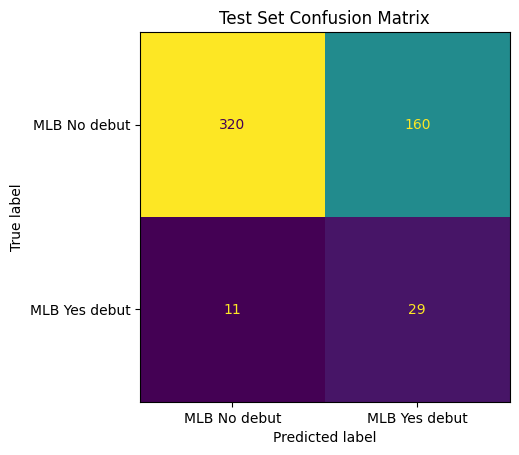

In [38]:
plot_confusion(y_test, y_pred_lr)

In [39]:
X_cv = tts_dataset_less_features.drop(columns=['MLB_debut'])
y_cv = tts_dataset_less_features['MLB_debut']

"""Compare evaluation metric between model families"""

#5-fold cross validation of the best model
cv_scores_lr = cross_val_score(lr_model, X_cv, y_cv, cv = 5, scoring = 'f1')
print("| Logistic Regression cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_lr):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_lr):.4f}")
print('-------------------------------------------------------------------------')

#5-fold cross validation of the 2nd best model
cv_scores_knn = cross_val_score(knn_model, X_cv, y_cv, cv = 5, scoring = 'f1')
print("| k-Nearest Neighbor cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_knn):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_knn):.4f}")
print('-------------------------------------------------------------------------')

#5-fold cross validation of the 3rd best model
cv_scores_et = cross_val_score(et_model, X_cv, y_cv, cv = 5, scoring = 'f1')
print("| Extra Trees cross validation |")
print(f"Mean F1-score: {np.mean(cv_scores_et):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_et):.4f}")

| Logistic Regression cross validation |
Mean F1-score: 0.3383
Standard Deviation: 0.1608
-------------------------------------------------------------------------
| k-Nearest Neighbor cross validation |
Mean F1-score: 0.0507
Standard Deviation: 0.0414
-------------------------------------------------------------------------
| Extra Trees cross validation |
Mean F1-score: 0.0200
Standard Deviation: 0.0400


In [40]:
auc=roc_auc_score(y_test, y_pred_lr)
print("Area under curve: ", auc)

Area under curve:  0.6958333333333334


In [41]:
#ROC-AUC curve
def plot_ROC(y_test, y_pred):
  fpr, tpr, thresholds = roc_curve(y_test,y_pred)

  plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
  plt.title('ROC curve')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.grid()
  plt.legend()
  plt.show()

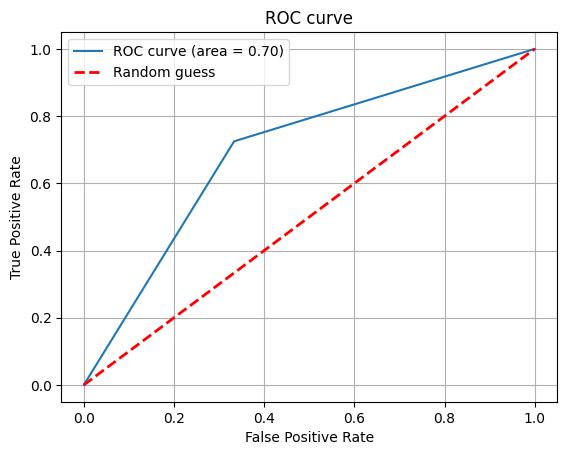

In [42]:
plot_ROC(y_test, y_pred_lr)

In [43]:
#Precision Recall curve
def plot_prc(X_test, y_test, y_pred, model):
  pr, re, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
  plt.plot(pr, re, linestyle='--', label='Precision Recall Curve')
  plt.xlabel('Precision')
  plt.ylabel('Recall')
  plt.legend()
  plt.show()

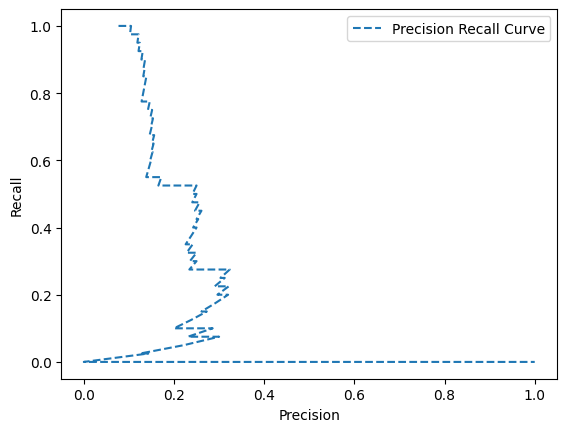

In [44]:
plot_prc(X_test,y_test,y_pred_lr,lr_model)

In [51]:
# Out of time validation

oot_original = milb_20_22_mlb_23_24.drop(columns=['CPX', 'DSL'])
oot_dataset_higher_levels  = oot_original.loc[:, less_features]

X_oot_new = oot_dataset_higher_levels.drop(columns = ['MLB_debut'])
y_oot_new = oot_dataset_higher_levels ['MLB_debut']

# Get predicted probabilities for the positive class (1)
y_probs_oot_new = lr_model.predict_proba(X_oot_new)[:, 1]

# Set a new threshold
threshold = 0.80
y_pred_oot_new = (y_probs_oot_new >= threshold).astype(int)


print(classification_report(y_oot_new, y_pred_oot_new))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2169
           1       0.50      0.32      0.39       109

    accuracy                           0.95      2278
   macro avg       0.73      0.65      0.68      2278
weighted avg       0.94      0.95      0.95      2278



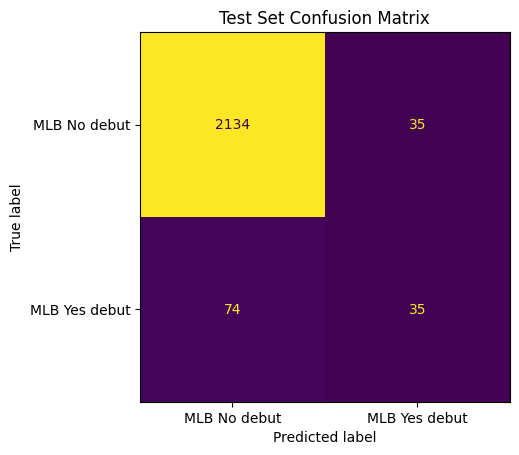

In [52]:
#Out of time validation confusion matrix
plot_confusion(y_oot_new, y_pred_oot_new)

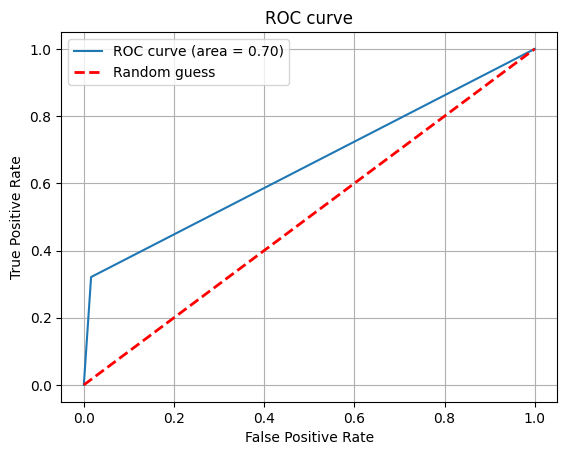

In [53]:
#ROC-AUC curve
plot_ROC(y_oot_new, y_pred_oot_new)

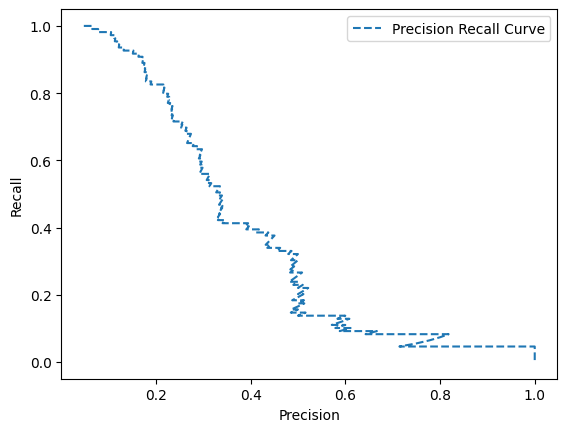

In [54]:
#Precision Recall curve
plot_prc(X_oot_new, y_oot_new, y_pred_oot_new, lr_model)

In [ ]:
# Predictions on who makes an MLB in 2025 or 2026
## Logistic Regression Model Used

#milb_22_24 = pd.read_csv('/content/team2_w25_milestone2_datafiles/Historical_MiLB_players_dataset_2022_2024.csv')

#future_mlb_full = age_level(milb_22_24)

# features = ['wRC', 'PA', 'wRC+', 'AVG', 'wRAA', 'max_age', 'wSB', 'BB/K', 'wOBA', 'SLG']
#features = ['wRC', 'wRC+', 'AVG', 'wSB', 'BB/K', 'SLG', 'ISO', 'OPS']
#future_mlb_less = future_mlb_full.loc[:, features]

#pred_fut_mlb = lr_model.predict(future_mlb_less)

#pred_fut_mlb


array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
"""Feature importance analysis"""

In [ ]:
"""Sensitivity analysis"""

In [ ]:
"""Failure analysis"""

# Unsupervised Learning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import warnings
!git clone https://github.com/jrsansom110515/team2_w25_milestone2_datafiles.git

Cloning into 'team2_w25_milestone2_datafiles'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 1.21 MiB | 1.90 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Function to load in datasets

def load_data_csv(files_list):

    # Replace the file path with your location.
    MiLB_df = pd.read_csv('/content/team2_w25_milestone2_datafiles/' + files_list)

    return MiLB_df

# Function to extract age and level

def age_level(MiLB_m_df):

    # Get max age
    MiLB_m_df['max_age'] = MiLB_m_df['Age'].apply(lambda x: x.split('-')[1]).astype(int)

    # Get levels into dummy variables
    dummy_df = MiLB_m_df['Level'].str.get_dummies(',')
    dummy_df['num_level'] = dummy_df.sum(axis = 1)
    MiLB_m_df = pd.concat([MiLB_m_df,dummy_df], axis=1)
    MiLB_m_df = MiLB_m_df.drop(columns=['Level', 'Age'])

    return MiLB_m_df

In [ ]:
milb = age_level(load_data_csv('Historical_MiLB_players_dataset_2022_2024.csv')) # Read file and format age/level
mlb_col = milb.drop(columns=['Name','Team','PlayerId']).columns

In [ ]:
# Normalize Data
milb_dev = np.array(milb.drop(columns=['Name','Team','PlayerId']))

scaler = StandardScaler().fit(milb_dev)
milb_norm = scaler.transform(milb_dev)

In [ ]:
# DBSCAN First Path
milb['DBSCAN_label']  = DBSCAN(eps = 5).fit_predict(milb_norm)

milb[milb['DBSCAN_label'] == -1] # -1 are outliers

,Name,Team,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,...,PlayerId,max_age,A,A+,AA,AAA,CPX,DSL,num_level,DBSCAN_label
2221,Chandler Simpson,TBR,1042,0.099808,0.087332,1.142857,0.325733,0.393792,0.374593,0.768385,...,sa3020219,23,1,1,1,0,1,0,4,-1


(-1.0, 100.0)

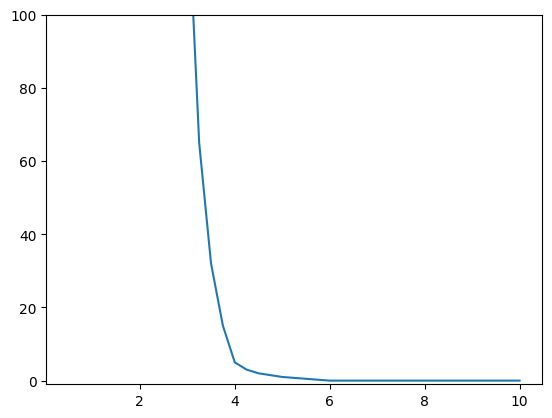

In [ ]:
# Run DBSCAN on multiple parameters to see how it changes
epsilons = [0.5,1,1.25,1.5,1.75,2,2.25,2.50,2.75,3,3.25,3.5,3.75,4,4.25,4.5,5,6,7,8,9,10]
num_out = []

for eps in epsilons:
    milb['DBSCAN_label']  = DBSCAN(eps = eps).fit_predict(milb_norm)
    num_out.append(sum(milb['DBSCAN_label'] == -1))

# This shows high sensitivity to the choice of variables
plt.plot(epsilons,num_out)
plt.ylim([-1,100])

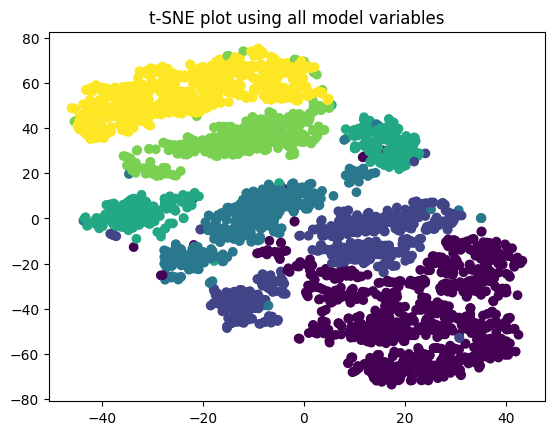

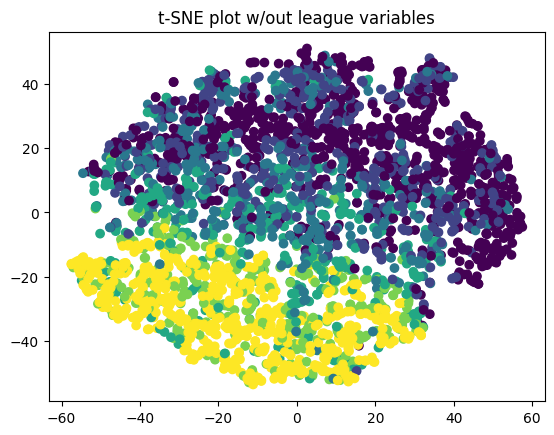

In [ ]:
# Visualizations using t-SNE
from sklearn.manifold import TSNE

best_league = milb[['AAA','AA','A+','A','CPX','DSL']].idxmax(axis=1) # Get Best league
# Create color mapping for graph
color_map = {category: idx for idx, category in enumerate(['AAA','AA','A+','A','CPX','DSL'])}
best_league_c = [color_map[cat] for cat in best_league]

# Create t-SNE and plot graph
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(milb_norm)
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=best_league_c)
plt.title('t-SNE plot using all model variables')
plt.show()

# When using league data, the model naturally clusters individuals into each league
# One interesting insight is that we see some individuals who are not outliers to a cluster
# but an outlier to their own league. This could indicate a need to run this model on each league.

# Create t-SNE and plot graph w/out league in the data
cols = [m not in ['AAA','AA','A+','A','CPX','DSL'] for m in mlb_col]
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(milb_norm[:,cols])
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=best_league_c)
plt.title('t-SNE plot w/out league variables')
plt.show()

# Despite the removal of league data, this indicate that the overall stats do tend to
# cluster around each league. Albeit with a lot more noise than before

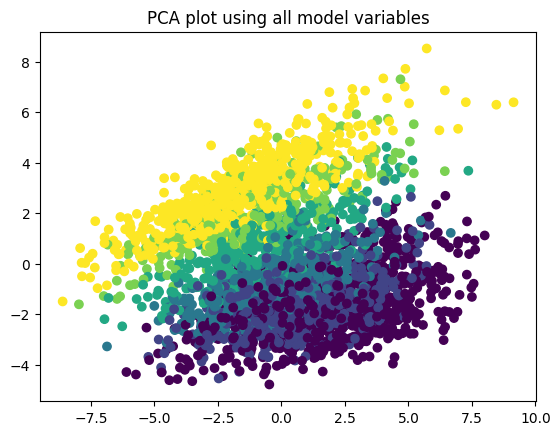

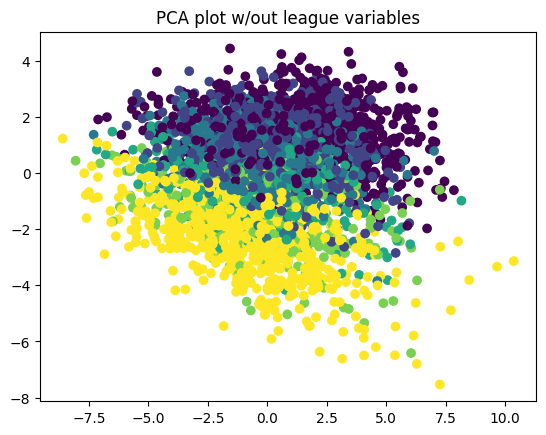

In [ ]:
from sklearn.decomposition import PCA

# Create PCA and plot graph
pca = PCA(n_components=2)
X_pca = pca.fit_transform(milb_norm)
plt.scatter(X_pca[:,0],X_pca[:,1],c=best_league_c)
plt.title('PCA plot using all model variables')
plt.show()

# Crete PCA and plot graph w/out league in the data
cols = [m not in ['AAA','AA','A+','A','CPX','DSL'] for m in mlb_col]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(milb_norm[:,cols])
plt.scatter(X_pca[:,0],X_pca[:,1],c=best_league_c)
plt.title('PCA plot w/out league variables')
plt.show()

In [ ]:
warnings.filterwarnings("ignore")

# Re-Run for each league level
# Run DBSCAN on multiple parameters to see how it changes
epsilons = [1.5,1.75,2,2.25,2.50,2.75,3,3.25,3.40,3.5,3.6,3.75,3.8,4,4.1,4.25,4.5,5,6,7,8,9,10]
num_out = []

for league in ['AAA','AA','A+','A','CPX','DSL']:
    milb_l = milb.loc[best_league == league,]
    milb_dev_l = milb_dev[best_league == league]
    milb_norm_l = normalize(milb_dev_l)
    cols = [m not in ['AAA','AA','A+','A','CPX','DSL','PA'] for m in mlb_col]


    num_o = []
    for eps in epsilons:
        milb_l.loc[:,'DBSCAN_label']  = DBSCAN(eps = eps).fit_predict(milb_norm_l[:,cols])
        num_o.append(sum(milb_l['DBSCAN_label'] == -1))
    num_out.append(num_o)

# This again shows high sensitivity to the choice of variables
# It seems that 3.5 is that sweet spot of identify a few true outliers
for num_o in num_out:
    plt.plot(epsilons,num_o)
plt.ylim([-1,100])
plt.locator_params(axis='x', nbins=20)

In [ ]:
# See results:
cols = [m not in ['AAA','AA','A+','A','CPX','DSL','PA'] for m in mlb_col]

for league in ['AAA','AA','A+','A','CPX','DSL']:
    milb_l = milb.loc[best_league == league,]
    milb_dev_l = milb_dev[best_league == league]
    milb_norm_l = normalize(milb_dev_l)

    milb_l['DBSCAN_label']  = DBSCAN(eps = 3.5).fit_predict(milb_norm_l)

    print(league)
    print(len(milb_l[milb_l['DBSCAN_label'] == -1]))
    print(milb_l[milb_l['DBSCAN_label'] == -1]['Name']) # -1 are outliers

In [ ]:
# Focus on the AAA players
milb_AAA = milb.loc[best_league == 'AAA',].drop(columns = ['DBSCAN_label'], errors = 'ignore')
milb_dev_AAA = milb_dev[best_league == 'AAA']
milb_norm_AAA = normalize(milb_dev_AAA)
cols = [m not in ['AAA','AA','A+','A','CPX','DSL','PA'] for m in mlb_col]

milb_AAA['DBSCAN_label']  = DBSCAN(eps = 3.5).fit_predict(milb_norm_AAA[:,cols])

print(len(milb_AAA[milb_AAA['DBSCAN_label'] == -1]))
milb_AAA[milb_AAA['DBSCAN_label'] == -1] # -1 are outliers

In [ ]:
# Create t-SNE and plot graph w/out league in the data
cols = [m not in ['AAA','AA','A+','A','CPX','DSL'] for m in mlb_col]
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(milb_norm_AAA[:,cols])
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = milb_AAA['DBSCAN_label'])
plt.title('t-SNE plot w/out league variables for AAA')
plt.show()

# Crete PCA and plot graph w/out league in the data
cols = [m not in ['AAA','AA','A+','A','CPX','DSL'] for m in mlb_col]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(milb_norm_AAA[:,cols])
plt.scatter(X_pca[:,0],X_pca[:,1], c = milb_AAA['DBSCAN_label'])
plt.title('PCA plot w/out league variables for AAA')
plt.show()

In [ ]:
# Focus on the AAA players
milb_AA = milb.loc[best_league == 'AA',].drop(columns = ['DBSCAN_label'], errors = 'ignore')
milb_dev_AA = milb_dev[best_league == 'AA']
milb_norm_AA = normalize(milb_dev_AA)
cols = [m not in ['AAA','AA','A+','A','CPX','DSL','PA'] for m in mlb_col]

milb_AA['DBSCAN_label']  = DBSCAN(eps = 3.5).fit_predict(milb_norm_AA[:,cols])

print(len(milb_AA[milb_AA['DBSCAN_label'] == -1]))
milb_AA[milb_AA['DBSCAN_label'] == -1] # -1 are outliers